In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [3]:
import torch
from torch import nn
from pyro import distributions as dist

In [4]:
import pyro
import deepppl
import os

In [5]:
import torch.utils.data.dataloader as dataloader
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST

In [6]:
plt.style.use('seaborn-white')


### Variational AutoEncoder example showing the interface of *DeepPPL*
This example uses two *NN* as black-box functions for which some parameters must be learned. Unlike the MLP example, no uncertainity is put on the NNs' parameters.

An important feature used for this example is the `batch_size`  parameter of the distribution functions.


``` stan
data {
    int x;
    int nz;
    int batch_size;
}



parameters {
    int latent;
}

networks {
    Decoder decoder;
    Encoder encoder;
}

guide {
    real encoded[2];
    real mu;
    real sigma;
    encoded = encoder(x);
    mu = encoded[1];
    sigma = encoded[2];
    latent ~ normal(mu, sigma, batch_size);
}

model {
    int loc_img;
    latent ~ normal(zeros(nz), ones(nz), batch_size);
    loc_img = decoder(latent);
    x ~ Bernoulli(loc_img);
}
```

In [7]:
batch_size, nx, nh, nz = 256, 28 * 28, 1024, 4

In [8]:
def loadData():
    train = MNIST(os.environ.get("DATA_DIR", '.') + "/data", train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),  # ToTensor does min-max normalization.
    ]), )

    test = MNIST(os.environ.get("DATA_DIR", '.') + "/data", train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),  # ToTensor does min-max normalization.
    ]), )

    dataloader_args = dict(shuffle=True, batch_size=batch_size,
                           num_workers=1, pin_memory=False)
    train_loader = dataloader.DataLoader(train, **dataloader_args)
    test_loader = dataloader.DataLoader(test, **dataloader_args)
    return train_loader, test_loader

###### Architecture.
Both  `Encoder` and `Decoder` are typical autoencoders except that the `Encoder` outputs a mean and variance for each instance


In [9]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.lh = nn.Linear(nz, nh)
        self.lx = nn.Linear(nh, nx)

    def forward(self, z):
        hidden = torch.relu(self.lh(z))
        mu = self.lx(hidden)
        return torch.sigmoid(mu.view(-1, 1, 28, 28))

# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.lh = torch.nn.Linear(nx, nh)
        self.lz_mu = torch.nn.Linear(nh, nz)
        self.lz_sigma = torch.nn.Linear(nh, nz)
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = x.view((-1, nx))
        hidden = torch.relu(self.lh(x))
        z_mu = self.lz_mu(hidden)
        z_sigma = self.softplus(self.lz_sigma(hidden))
        return z_mu, z_sigma

In [10]:
train_loader, test_loader = loadData()

In [11]:
encoder = Encoder()
decoder = Decoder()

In [12]:
pyro.clear_param_store()

In [13]:
model = deepppl.PyroModel(model_file = '../tests/good/vae.stan', 
                           encoder = encoder, 
                           decoder = decoder)

svi = model.svi(params = {'lr' : 0.01})

ANTLR runtime and generated code versions disagree: 4.7.2!=4.8
ANTLR runtime and generated code versions disagree: 4.7.2!=4.8


In [14]:
for epoch in tqdm(range(4), desc='epoch'):  # loop over the dataset multiple times
    running_loss = 0.0
    t = tqdm(enumerate(train_loader, 0), desc='mini_batch')
    for j, (imgs, _) in t:
        # calculate the loss and take a gradient step
        loss = svi.step(nz, imgs)
        t.set_postfix(loss = loss)

Get latent representation of `imgs`
=====

In [15]:
z_loc, z_scale = encoder(imgs)

decoded = decoder(dist.Normal(z_loc, z_scale).sample())

Plot probabilities for each pixel
======

(-0.5, 27.5, 27.5, -0.5)

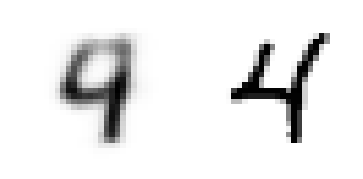

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(decoded[0].data.squeeze().numpy())
ax2.imshow(imgs[0].squeeze().numpy())
ax1.axis('off')
ax2.axis('off')

Sample one possible image
======

In [17]:
sample = dist.Bernoulli(decoded[0]).sample()

(-0.5, 27.5, 27.5, -0.5)

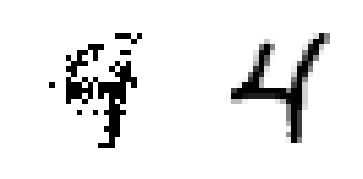

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(sample.data.squeeze().numpy())
ax2.imshow(imgs[0].squeeze().numpy())
ax1.axis('off')
ax2.axis('off')